In [1]:
import gc
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np

# builder modules
import builders
# import builders_rwx

# solver modules
from classic_solvers import *
import lp_solvers
# import lp_solvers_rwx

In [2]:
# do auto reload
%load_ext autoreload
%autoreload 2

In [4]:
def gen_graphs(graph_dir, n_vals, graph_params, K=5, S=5):
    os.makedirs(graph_dir, exist_ok=True)

    # Metadata to be saved separately
    metadata = {
        "n_vals": n_vals,
        "graph_params": graph_params,
        "graph_files": [],
    }

    for n in n_vals:
        # Directory to store graphs for this specific `n`
        n_dir = os.path.join(graph_dir, f"n_{n}")
        os.makedirs(n_dir, exist_ok=True)

        for idx in range(K):
            # Build the graph
            G = builders.gen_graph(graph_params, n)

            # Sample source-sink pairs
            source_sink_pairs = builders.sample_node_pairs(G, S)

            # Prepare data for this graph
            graph_data = {
                "graph": G,
                "source_sink_pairs": source_sink_pairs,
            }

            # Save each graph individually
            graph_file = os.path.join(n_dir, f"graph_{idx}.pkl")
            with open(graph_file, 'wb') as file:
                pickle.dump(graph_data, file)

            # Add to metadata
            metadata["graph_files"].append(graph_file)

            del G
            gc.collect()

    # Save metadata
    metadata_file = os.path.join(graph_dir, "metadata.pkl")
    with open(metadata_file, 'wb') as file:
        pickle.dump(metadata, file)

    print(f"Graphs saved to {graph_dir}")

In [5]:
graphs_folder = 'graphs'
n_vals = list(map(int, np.logspace(np.log10(10), np.log10(1000), 10)))
print(n_vals)

# # List of parameter dictionaries
# param_dicts = [
#     {'type': 'complete'},
#     {'type': 'tree'},
#     {'type': 'erdos-renyi', 'p': 0.01},
#     {'type': 'barabasi-albert', 'm': 2},
# ]

param_dicts = [
    {'type': 'erdos-renyi', 'p': 0.01},
]


# Loop through parameter dictionaries and run the generate_graphs function
for params in param_dicts:
    gen_graphs(os.path.join(graphs_folder, params['type']), n_vals, params, K=5, S=10)


[10, 16, 27, 46, 77, 129, 215, 359, 599, 1000]
Graphs saved to graphs/erdos-renyi


In [6]:
def compute_solve_times(methods, graph_dir, limit = None):
    # Load metadata
    metadata_file = os.path.join(graph_dir, "metadata.pkl")
    with open(metadata_file, 'rb') as file:
        metadata = pickle.load(file)

    n_vals = metadata['n_vals']

    if limit is not None:
        n_vals = n_vals[:limit]

    graph_files = metadata['graph_files']
    graph_files_by_n = {}

    # Organize graph files by their respective n values
    for graph_file in graph_files:
        n = int(os.path.basename(os.path.dirname(graph_file)).split('_')[1])
        graph_files_by_n.setdefault(n, []).append(graph_file)

    # Initialize data structures to store solve times
    solve_times = {method_name: {n: [] for n in n_vals} for _, method_name in methods}

    print(f"Beginning solves for {graph_dir}")
    for n in n_vals:
        print(f"Processing solves for n={n}")

        # Process each graph file for the current n
        for graph_file in graph_files_by_n.get(n, []):
            with open(graph_file, 'rb') as file:
                graph_data = pickle.load(file)

            G = graph_data['graph']
            ss_pairs = graph_data['source_sink_pairs']

            for s, t in ss_pairs:
                for method, method_name in methods:
                    sol = method(G, s, t)
                    # Append the run_time to the solve_times
                    solve_times[method_name][n].append(sol['run_time'])

    return solve_times, n_vals, metadata

In [7]:
def plot_solve_times(solve_times, n_vals, metadata):
    # Initialize data structures for averages per method
    averages = {method_name: [] for method_name in solve_times}

    # Compute average solve times per method at each n
    for method_name in solve_times:
        for n in n_vals:
            times = solve_times[method_name][n]
            if times:
                avg_time = sum(times) / len(times)
            else:
                avg_time = 0
            averages[method_name].append(avg_time)

    # Compute standard deviation across methods at each n
    stddevs_across_methods = []
    for idx, n in enumerate(n_vals):
        avg_times_at_n = [averages[method_name][idx] for method_name in averages]
        stddev_across_methods = np.std(avg_times_at_n)
        stddevs_across_methods.append(stddev_across_methods)

    # Plot average solve times with logarithmic y-axis
    plt.figure(figsize=(10, 6))
    for method_name in averages:
        plt.plot(n_vals, averages[method_name], marker='o', label=method_name)

    plt.xlabel('Number of Nodes (n)')
    plt.ylabel('Average Runtime (seconds)')
    plt.title(f"Average Max-Flow Computation Time vs. Graph Size ({metadata['graph_params']['type']})")
    plt.legend()
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.yscale('log')  # Apply logarithmic scale to y-axis
    plt.show()

    # Plot standard deviation across methods with logarithmic y-axis
    plt.figure(figsize=(10, 6))
    plt.plot(n_vals, stddevs_across_methods, marker='o')
    plt.xlabel('Number of Nodes (n)')
    plt.ylabel('Standard Deviation of Average Runtime Across Methods (seconds)')
    plt.title(
        f"Stdev of Average Max-Flow Computation Time vs. Graph Size ({metadata['graph_params']['type']})")
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.yscale('log')  # Apply logarithmic scale to y-axis
    plt.show()


Beginning solves for ./graphs/tree
Processing solves for n=10
Processing solves for n=16
Processing solves for n=27
Processing solves for n=46
Processing solves for n=77
Processing solves for n=129
Processing solves for n=215
Processing solves for n=359
Processing solves for n=599
Processing solves for n=1000


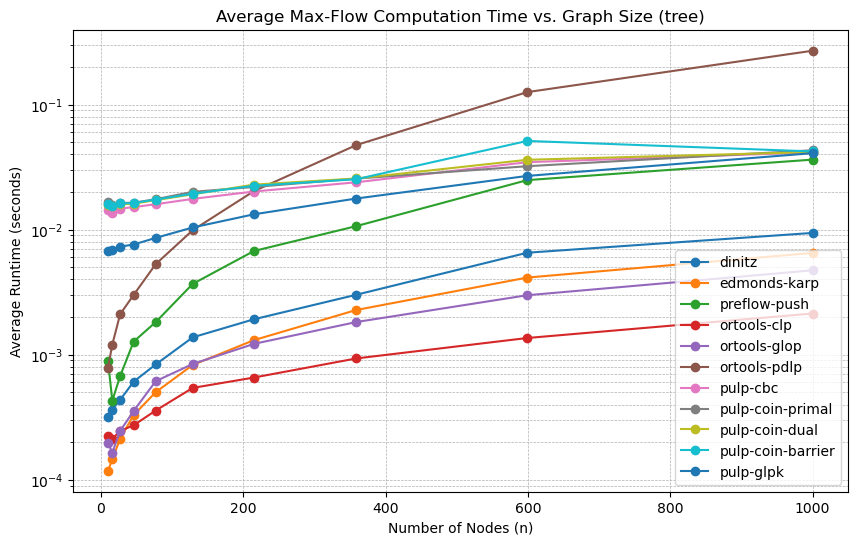

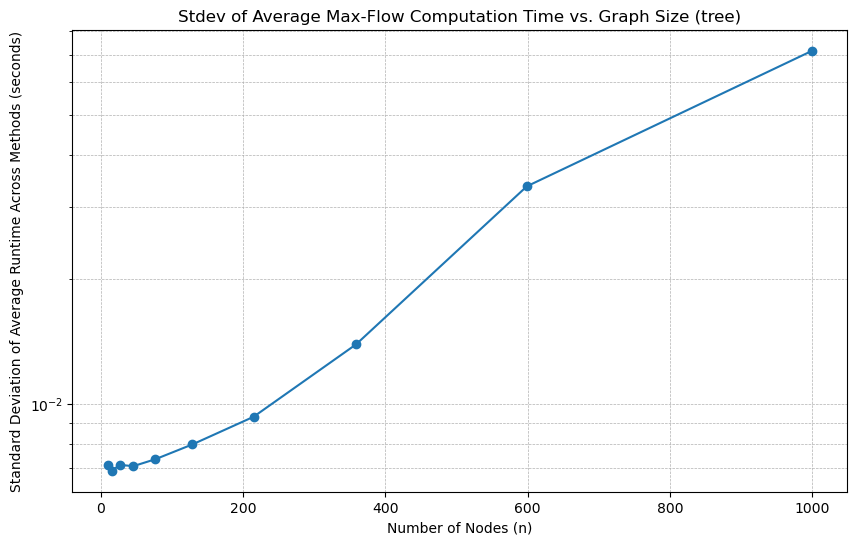

In [6]:
methods = [
    (max_flow_dinitz, 'dinitz'),
    (max_flow_edmonds_karp, 'edmonds-karp'),
    (max_flow_preflow_push, 'preflow-push'),
    (lp_solvers.max_flow_ortools_CLP, 'ortools-clp'),
    (lp_solvers.max_flow_ortools_GLOP, 'ortools-glop'),
    (lp_solvers.max_flow_ortools_PDLP, 'ortools-pdlp'),
    (lp_solvers.max_flow_pulp_CBC, 'pulp-cbc'),
    (lp_solvers.max_flow_pulp_COIN_primal, 'pulp-coin-primal'),
    (lp_solvers.max_flow_pulp_COIN_dual, 'pulp-coin-dual'),
    (lp_solvers.max_flow_pulp_COIN_barrier, 'pulp-coin-barrier'),
    (lp_solvers.max_flow_pulp_GLPK, 'pulp-glpk')
]
graph_dir = './graphs/tree'

# Compute the solve times
solve_times, n_vals, metadata = compute_solve_times(methods, graph_dir)

# Plot the results
plot_solve_times(solve_times, n_vals, metadata)

Beginning solves for ./graphs/complete
Processing solves for n=10
Processing solves for n=16
Processing solves for n=27
Processing solves for n=46
Processing solves for n=77
Processing solves for n=129
Processing solves for n=215


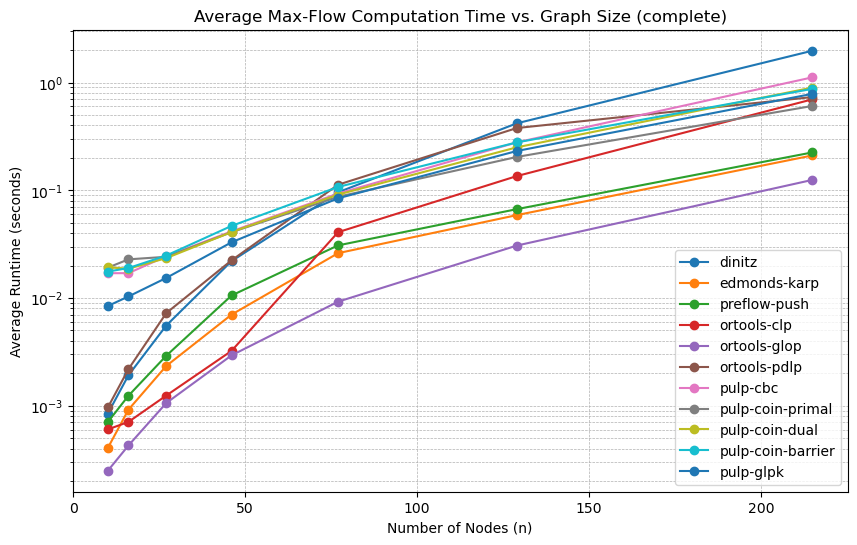

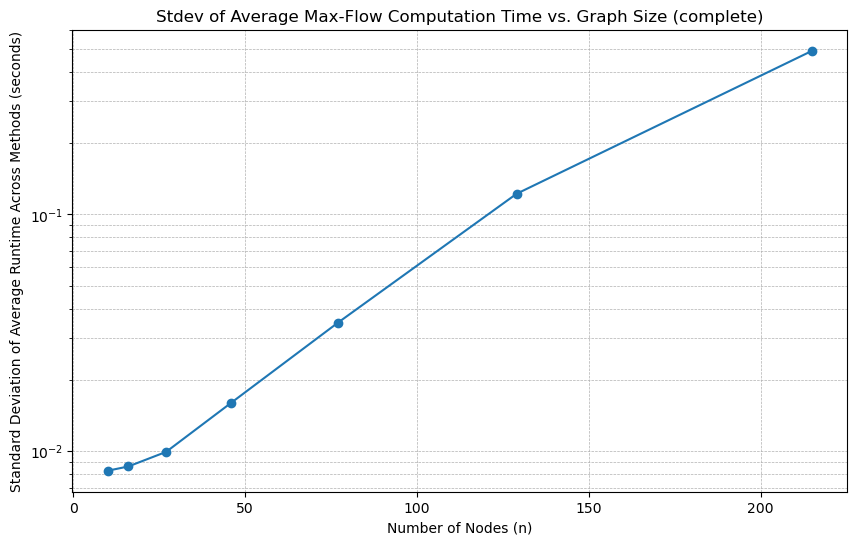

In [10]:
methods = [
    (max_flow_dinitz, 'dinitz'),
    (max_flow_edmonds_karp, 'edmonds-karp'),
    (max_flow_preflow_push, 'preflow-push'),
    (lp_solvers.max_flow_ortools_CLP, 'ortools-clp'),
    (lp_solvers.max_flow_ortools_GLOP, 'ortools-glop'),
    (lp_solvers.max_flow_ortools_PDLP, 'ortools-pdlp'),
    (lp_solvers.max_flow_pulp_CBC, 'pulp-cbc'),
    (lp_solvers.max_flow_pulp_COIN_primal, 'pulp-coin-primal'),
    (lp_solvers.max_flow_pulp_COIN_dual, 'pulp-coin-dual'),
    (lp_solvers.max_flow_pulp_COIN_barrier, 'pulp-coin-barrier'),
    (lp_solvers.max_flow_pulp_GLPK, 'pulp-glpk')
]
graph_dir = './graphs/complete'

# Compute the solve times
solve_times, n_vals, metadata = compute_solve_times(methods, graph_dir, limit=7)

# Plot the results
plot_solve_times(solve_times, n_vals, metadata)

Beginning solves for ./graphs/barabasi-albert
Processing solves for n=10
Processing solves for n=16
Processing solves for n=27
Processing solves for n=46
Processing solves for n=77
Processing solves for n=129
Processing solves for n=215
Processing solves for n=359
Processing solves for n=599
Processing solves for n=1000


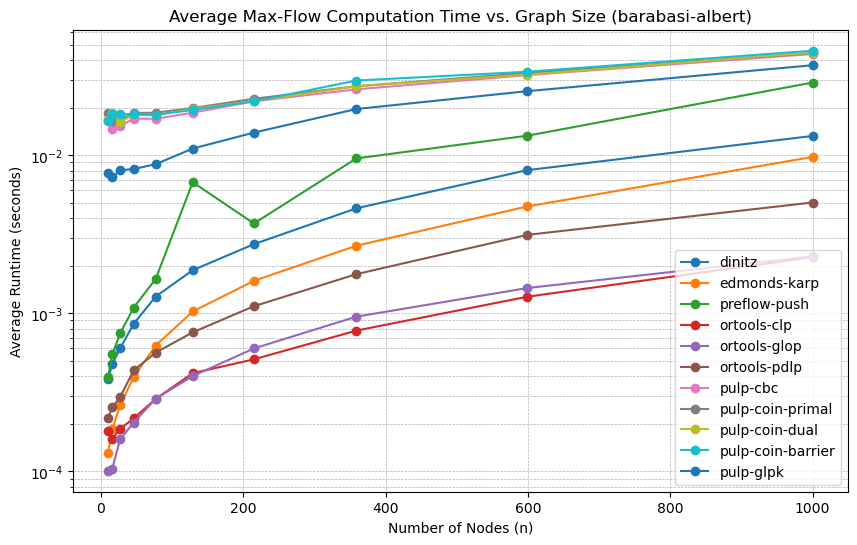

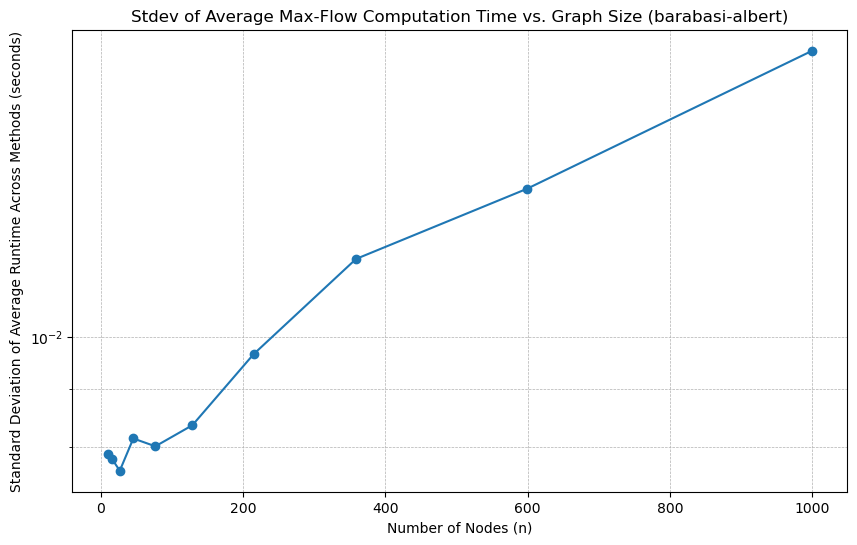

In [12]:
methods = [
    (max_flow_dinitz, 'dinitz'),
    (max_flow_edmonds_karp, 'edmonds-karp'),
    (max_flow_preflow_push, 'preflow-push'),
    (lp_solvers.max_flow_ortools_CLP, 'ortools-clp'),
    (lp_solvers.max_flow_ortools_GLOP, 'ortools-glop'),
    (lp_solvers.max_flow_ortools_PDLP, 'ortools-pdlp'),
    (lp_solvers.max_flow_pulp_CBC, 'pulp-cbc'),
    (lp_solvers.max_flow_pulp_COIN_primal, 'pulp-coin-primal'),
    (lp_solvers.max_flow_pulp_COIN_dual, 'pulp-coin-dual'),
    (lp_solvers.max_flow_pulp_COIN_barrier, 'pulp-coin-barrier'),
    (lp_solvers.max_flow_pulp_GLPK, 'pulp-glpk')
]
graph_dir = './graphs/barabasi-albert'

# Compute the solve times
solve_times, n_vals, metadata = compute_solve_times(methods, graph_dir)

# Plot the results
plot_solve_times(solve_times, n_vals, metadata)

Beginning solves for ./graphs/erdos-renyi
Processing solves for n=10
Processing solves for n=16
Processing solves for n=27
Processing solves for n=46
Processing solves for n=77
Processing solves for n=129
Processing solves for n=215
Processing solves for n=359
Processing solves for n=599
Processing solves for n=1000


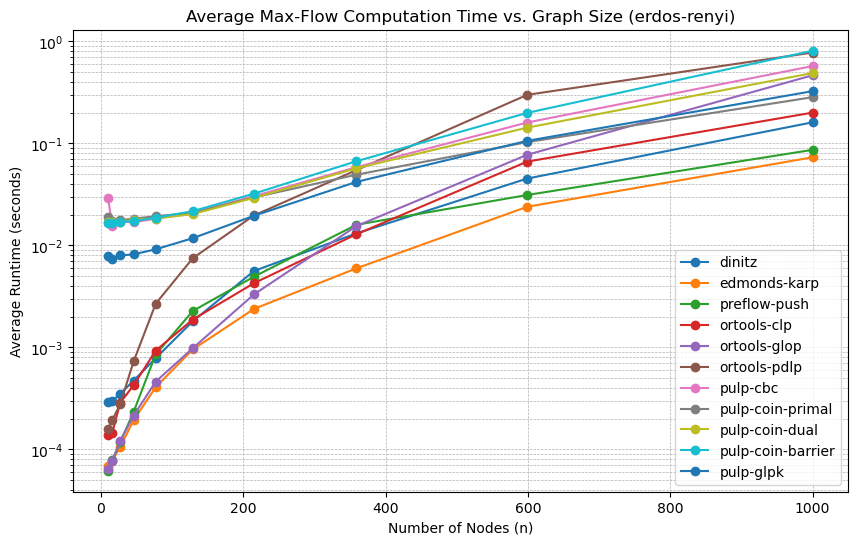

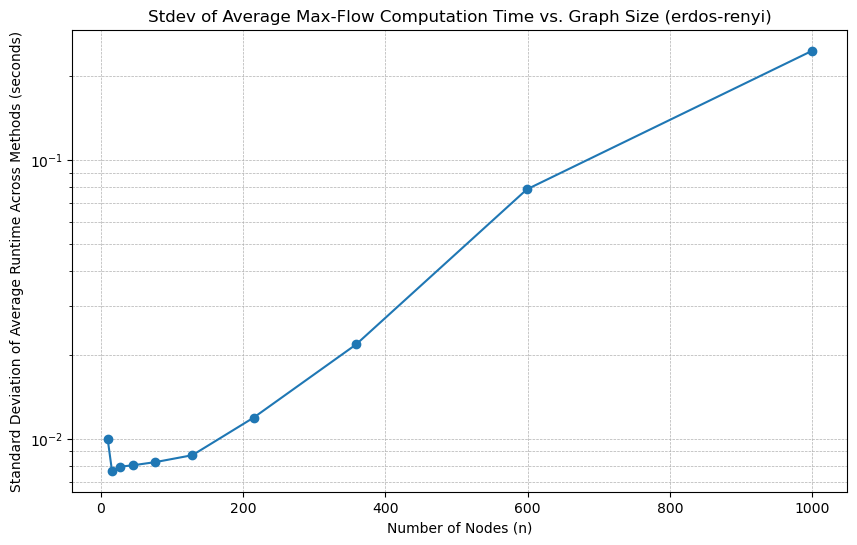

In [9]:
methods = [
    (max_flow_dinitz, 'dinitz'),
    (max_flow_edmonds_karp, 'edmonds-karp'),
    (max_flow_preflow_push, 'preflow-push'),
    (lp_solvers.max_flow_ortools_CLP, 'ortools-clp'),
    (lp_solvers.max_flow_ortools_GLOP, 'ortools-glop'),
    (lp_solvers.max_flow_ortools_PDLP, 'ortools-pdlp'),
    (lp_solvers.max_flow_pulp_CBC, 'pulp-cbc'),
    (lp_solvers.max_flow_pulp_COIN_primal, 'pulp-coin-primal'),
    (lp_solvers.max_flow_pulp_COIN_dual, 'pulp-coin-dual'),
    (lp_solvers.max_flow_pulp_COIN_barrier, 'pulp-coin-barrier'),
    (lp_solvers.max_flow_pulp_GLPK, 'pulp-glpk')
]
graph_dir = './graphs/erdos-renyi'

# Compute the solve times
solve_times, n_vals, metadata = compute_solve_times(methods, graph_dir)

# Plot the results
plot_solve_times(solve_times, n_vals, metadata)

In [3]:
import builders_rx

def gen_graphs_rx(graph_dir, n_vals, graph_params, K=5, S=5):
    os.makedirs(graph_dir, exist_ok=True)

    # Metadata to be saved separately
    metadata = {
        "n_vals": n_vals,
        "graph_params": graph_params,
        "graph_files": [],
    }

    for n in n_vals:
        # Directory to store graphs for this specific `n`
        n_dir = os.path.join(graph_dir, f"n_{n}")
        os.makedirs(n_dir, exist_ok=True)

        for idx in range(K):
            # Build the graph
            G = builders_rx.gen_graph(graph_params, n)

            # Sample source-sink pairs
            source_sink_pairs = builders_rx.sample_node_pairs(G, S)

            # Prepare data for this graph
            graph_data = {
                "graph": G,
                "source_sink_pairs": source_sink_pairs,
            }

            # Save each graph individually
            graph_file = os.path.join(n_dir, f"graph_{idx}.pkl")
            with open(graph_file, 'wb') as file:
                pickle.dump(graph_data, file)

            # Add to metadata
            metadata["graph_files"].append(graph_file)

            del G
            gc.collect()

    # Save metadata
    metadata_file = os.path.join(graph_dir, "metadata.pkl")
    with open(metadata_file, 'wb') as file:
        pickle.dump(metadata, file)

    print(f"Graphs saved to {graph_dir}")

In [13]:
graphs_folder = 'graphs_rx'
n_vals = list(map(int, np.logspace(np.log10(10), np.log10(10000), 5)))
print(n_vals)

p_values = [0.1,0.5,0.9]

param_dicts = [{'type': 'sparse-ill-conditioned', 'edge_factor': 1.1, 'small_capacity_fraction': p, 'scaling_factor': 4} for p in p_values]

# Loop through parameter dictionaries and run the generate_graphs function
for params in param_dicts:
    gen_graphs_rx(os.path.join(graphs_folder, f"{params['type']}-{params['small_capacity_fraction']}"), n_vals, params, K=5, S=10)

[10, 56, 316, 1778, 10000]
Graphs saved to graphs_rx/sparse-ill-conditioned-0.1
Graphs saved to graphs_rx/sparse-ill-conditioned-0.5
Graphs saved to graphs_rx/sparse-ill-conditioned-0.9


Beginning solves for ./graphs_rx/sparse-ill-conditioned-0.5
Processing solves for n=10
Processing solves for n=56
Processing solves for n=316
Processing solves for n=1778
Processing solves for n=10000


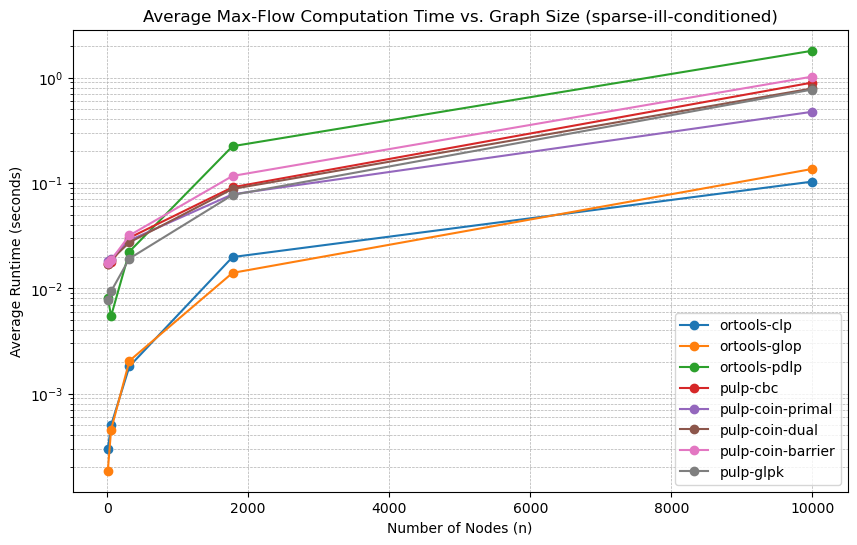

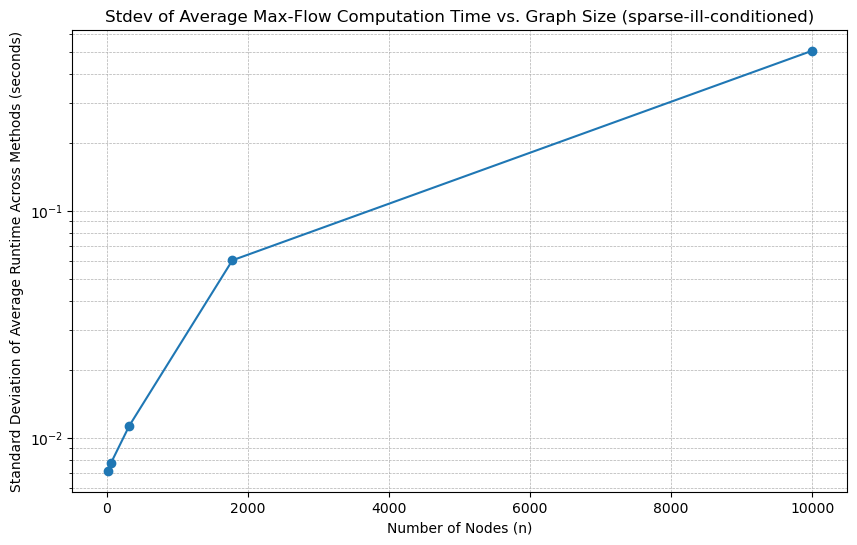

In [14]:
import lp_solvers_rx

methods = [
    (lp_solvers_rx.max_flow_ortools_CLP, 'ortools-clp'),
    (lp_solvers_rx.max_flow_ortools_GLOP, 'ortools-glop'),
    (lp_solvers_rx.max_flow_ortools_PDLP, 'ortools-pdlp'),
    (lp_solvers_rx.max_flow_pulp_CBC, 'pulp-cbc'),
    (lp_solvers_rx.max_flow_pulp_COIN_primal, 'pulp-coin-primal'),
    (lp_solvers_rx.max_flow_pulp_COIN_dual, 'pulp-coin-dual'),
    (lp_solvers_rx.max_flow_pulp_COIN_barrier, 'pulp-coin-barrier'),
    (lp_solvers_rx.max_flow_pulp_GLPK, 'pulp-glpk')
]


graph_dir = './graphs_rx/sparse-ill-conditioned-0.5'

# Compute the solve times
solve_times, n_vals, metadata = compute_solve_times(methods, graph_dir)

# Plot the results
plot_solve_times(solve_times, n_vals, metadata)

In [15]:
graphs_folder = 'graphs_rx_counter'
n_vals = list(map(int, np.logspace(np.log10(10), np.log10(10000), 5)))
print(n_vals)

p_values = [0.1,0.5,0.9]

param_dicts = [{'type': 'sparse-ill-conditioned', 'edge_factor': 1.1, 'small_capacity_fraction': p, 'scaling_factor': 0} for p in p_values]

# Loop through parameter dictionaries and run the generate_graphs function
for params in param_dicts:
    gen_graphs_rx(os.path.join(graphs_folder, f"{params['type']}-{params['small_capacity_fraction']}"), n_vals, params, K=5, S=10)

[10, 56, 316, 1778, 10000]
Graphs saved to graphs_rx_counter/sparse-ill-conditioned-0.1
Graphs saved to graphs_rx_counter/sparse-ill-conditioned-0.5
Graphs saved to graphs_rx_counter/sparse-ill-conditioned-0.9


Beginning solves for ./graphs_rx_counter/sparse-ill-conditioned-0.5
Processing solves for n=10
Processing solves for n=56
Processing solves for n=316
Processing solves for n=1778
Processing solves for n=10000


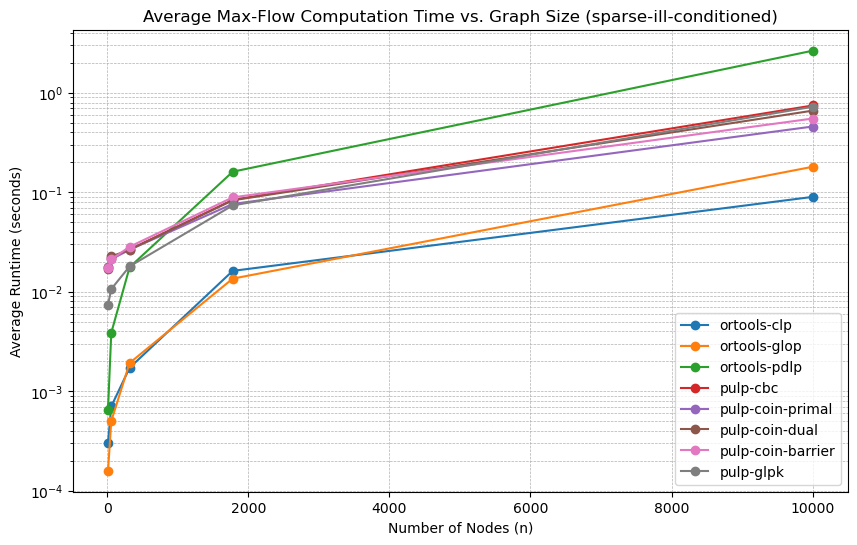

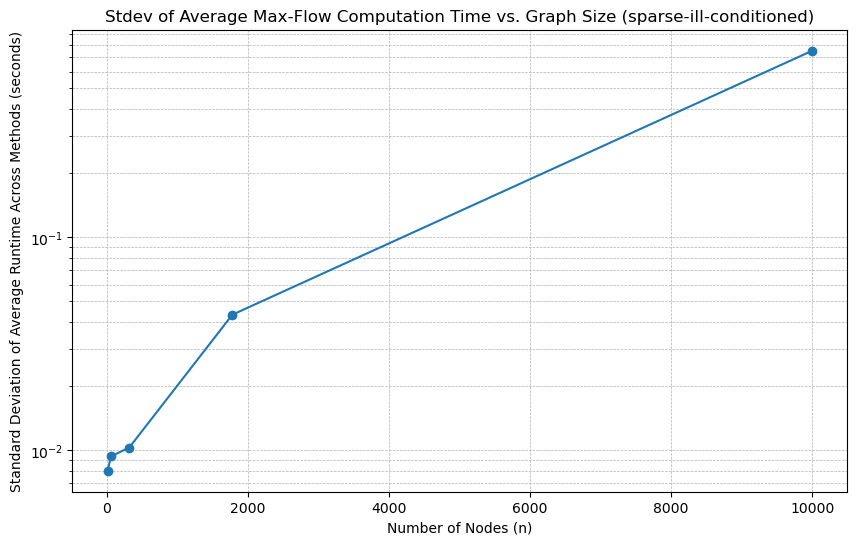

In [16]:
import lp_solvers_rx

methods = [
    (lp_solvers_rx.max_flow_ortools_CLP, 'ortools-clp'),
    (lp_solvers_rx.max_flow_ortools_GLOP, 'ortools-glop'),
    (lp_solvers_rx.max_flow_ortools_PDLP, 'ortools-pdlp'),
    (lp_solvers_rx.max_flow_pulp_CBC, 'pulp-cbc'),
    (lp_solvers_rx.max_flow_pulp_COIN_primal, 'pulp-coin-primal'),
    (lp_solvers_rx.max_flow_pulp_COIN_dual, 'pulp-coin-dual'),
    (lp_solvers_rx.max_flow_pulp_COIN_barrier, 'pulp-coin-barrier'),
    (lp_solvers_rx.max_flow_pulp_GLPK, 'pulp-glpk')
]


graph_dir = './graphs_rx_counter/sparse-ill-conditioned-0.5'

# Compute the solve times
solve_times, n_vals, metadata = compute_solve_times(methods, graph_dir)

# Plot the results
plot_solve_times(solve_times, n_vals, metadata)